In [1]:
import numpy as np
from learned_ctrlr_opt.systems.upkie.upkie import DelayedUpkieSystem, WheeledInvertedPendulumParams, MPCBalancerParams
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
params = WheeledInvertedPendulumParams(leg_length=0.8, wheel_radius=0.06, action_lpf=0.0, mpc_sampling_period=0.05)
robot = DelayedUpkieSystem(params=params, time_horizon_s=5)

In [21]:
num_gains = 10
all_metrics = np.zeros((num_gains, num_gains, 3))
all_lengths = np.linspace(MPCBalancerParams.get_bounds()[0,0], MPCBalancerParams.get_bounds()[0,1], num_gains)
all_radii = np.linspace(MPCBalancerParams.get_bounds()[1,0], MPCBalancerParams.get_bounds()[1,1], num_gains)

for i in range(num_gains):
    for j in range(num_gains):
        gains = MPCBalancerParams(leg_length=all_lengths[i], wheel_radius=all_radii[j]).get_list()
        metrics, traj = robot.evaluate_gain(gains, init_state=np.array([0, 0.01, 0.0, 0.02]))
        all_metrics[i,j] = metrics

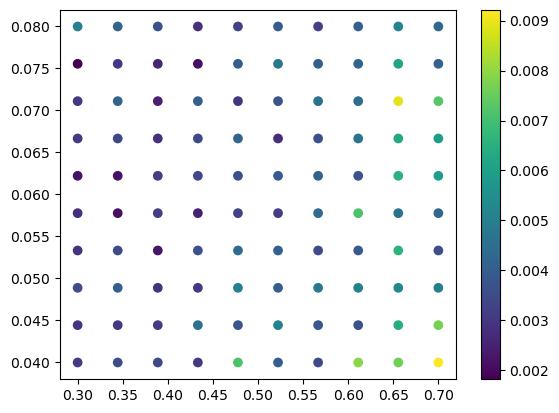

In [25]:
xx,yy = np.meshgrid([i for i in range(num_gains)], [i for i in range(num_gains)])
plt.scatter(all_lengths[xx.flatten()], all_radii[yy.flatten()], c=all_metrics[...,0].flatten())
plt.colorbar()

# Evaluate Upkie OCCAM Model

In [5]:
import matplotlib.pyplot as plt
import h5py
import torch.optim
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import DataLoader
from datetime import datetime
import os
from omegaconf import OmegaConf
import time

from learned_ctrlr_opt.utils.learning_utils import init_weights, create_network
from learned_ctrlr_opt.utils.experiment_utils import *
from learned_ctrlr_opt.meta_learning.lsr_net import *
from learned_ctrlr_opt.meta_learning.basis_kf import *
from learned_ctrlr_opt.meta_learning.utils import get_sysid_history_dataset, get_scalers
from learned_ctrlr_opt.opt.random_search import *

In [6]:
kf_checkpoint_dir = "model_checkpoints/upkie_mpc_lstsq_net/leafy-lion-645_Sep_27_2024/"

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

kf_cfg = OmegaConf.load(os.path.join(kf_checkpoint_dir, "config.yaml"))

# load scalers
scalers = get_scalers(kf_cfg.path_to_dataset, kf_cfg.history_length, kf_cfg.metric_idxs, kf_cfg.metric_idxs_to_invert)
gain_scaler = scalers[0]
metric_scaler = scalers[2]

gain_dim = len(kf_cfg.gains_to_optimize)
initial_state_dim = 4

kf_network = LSRBasisNet(in_size=gain_dim + initial_state_dim,
                         n_bases=kf_cfg.n_bases,
                         n_targets=len(kf_cfg.metric_idxs),
                         layer_sizes=kf_cfg.layer_sizes,
                         nonlin=kf_cfg.nonlin).float().train().to(device)


kf_network.load_state_dict(torch.load(os.path.join(kf_checkpoint_dir, "model_epoch_145.pt")))
kf_network.use_last_layer = False
kf_network = kf_network.eval().to(device)

dset_f = h5py.File(kf_cfg.path_to_dataset, 'r')
ref_tracks_enc = np.array(dset_f["reference_tracks_enc"])
ref_track_scaler = MinMaxScaler(clip=True).fit(ref_tracks_enc.reshape(-1, ref_tracks_enc.shape[-1]))
dset_f.close()

/tmp/ipykernel_1810532/3018529769.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  kf_network.load_state_dict(torch.load(os.path.join(kf_checkpoint_dir, "model_epoch_145

In [138]:
params = WheeledInvertedPendulumParams(leg_length=0.58, wheel_radius=0.06, action_lpf=0.0, mpc_sampling_period=0.06)
robot = DelayedUpkieSystem(params=params, time_horizon_s=1)

num_trials = 30

initial_state_bounds = np.array([[0, 0],
                                 [-0.04, 0.04],
                                 [-0.15, 0.15],
                                 [-0.02, 0.02]])

In [140]:
weights = kf_network.last_layer_prior
sigma = torch.mm(kf_network.last_layer_prior_cov_sqrt, torch.t(kf_network.last_layer_prior_cov_sqrt)).float().to(device)
Q = torch.mm(kf_network.Q_sqrt, torch.t(kf_network.Q_sqrt)).float().to(device)
R = torch.mm(kf_network.R_sqrt, torch.t(kf_network.R_sqrt)).float().to(device)

perf_metrics = np.zeros((num_trials, 3))
actual_rwds = np.zeros(num_trials)
expected_rwds = np.zeros(num_trials)
tried_gains= np.zeros((num_trials, 2))
cost_weights = np.array([-0.33, -0.33, -0.33])
full_traj = []

task_input_data = torch.zeros(num_trials, gain_dim + initial_state_dim)
task_target_data = torch.zeros(num_trials, len(kf_cfg.metric_idxs))
init_state_fixed = denormalize(np.random.rand(4), initial_state_bounds)

init_state = init_state_fixed
for i in range(num_trials):
    def eval_fn(x, cost_weights, sigma_weight):
        q = x.size(0)
        cost_weights = torch.from_numpy(cost_weights).float().to(device)
        ys, sigmas = last_layer_prediction_uncertainty_aware(x.float().to(device), kf_network, weights, sigma)
        cost_weights_batch = cost_weights.repeat(q).reshape((q, cost_weights.shape[-1])).to(device)
        mean_losses = torch.sum(ys * cost_weights_batch, dim=-1)
        variances = torch.zeros(x.size(0)).to(device)
        for j in range(x.size(0)):
            inter = torch.mm(sigmas[j], cost_weights.unsqueeze(-1))
            variances[j] = torch.mm(torch.t(cost_weights.unsqueeze(-1)), inter)
        losses = mean_losses + sigma_weight * variances
        return losses, ys, variances

    init_state_enc = torch.from_numpy(ref_track_scaler.transform(init_state.reshape(1, -1))).float().squeeze()
    results = random_search(eval_fn,
                            256,
                            cost_weights,
                            gain_dim,
                            device,
                            init_state_enc,
                            batch_size=256,
                            sigma_weight=-0.01,
                            guaranteed_searches=None)
    best_gain = results[0]
    best_y = results[2]
    best_gain_unscaled = np.squeeze(gain_scaler.inverse_transform(best_gain.unsqueeze(0).detach().cpu().numpy()))
    metrics, traj = robot.evaluate_gain(best_gain_unscaled, init_state=init_state)
    for t in range(traj.shape[0]):
        full_traj.append(traj[t])
    
    metrics_scaled = np.squeeze(metric_scaler.transform(np.expand_dims(metrics, 0)))
    actual_rwd = np.dot(cost_weights, metrics_scaled)
    print(f"step {i}: actual cost = {actual_rwd}")
    print(f"step {i}: expected cost = {best_y}")
    print(f"step {i}: best gain = {best_gain_unscaled}")
    print(f"step {i}: metrics = {metrics}")
    print("------------------------")
    
    perf_metrics[i] = metrics
    actual_rwds[i] = actual_rwd
    expected_rwds[i] = best_y

    if not np.any(traj[-1]):
        print("resetting!")
        init_state = init_state_fixed
    else:
        init_state = traj[-1]
    
    phi = kf_network(torch.cat([best_gain, init_state_enc], dim=-1).float().to(device).unsqueeze(0)).squeeze()
    target = torch.from_numpy(metrics_scaled).float().to(device).squeeze()
    with torch.no_grad():
        weights, sigma, K = kalman_step(weights, sigma, target.float().to(device), phi, Q, R)

step 0: actual cost = -0.49172861933984124
step 0: expected cost = -0.7309700149297715
step 0: best gain = [0.55576676 0.04002758]
step 0: metrics = [0.01618797 0.22778053 5.2884756 ]
------------------------
step 1: actual cost = -0.20850881168382507
step 1: expected cost = 0.41907676398754123
step 1: best gain = [0.6514172  0.07113098]
step 1: metrics = [0.01291628 0.23234356 3.70311985]
------------------------
step 2: actual cost = 0.33208937031637525
step 2: expected cost = 0.41739167511463166
step 2: best gain = [0.38666922 0.04093649]
step 2: metrics = [0.01097312 0.04235462 5.00762535]
------------------------
step 3: actual cost = 0.8105507346688539
step 3: expected cost = 0.6466281992197036
step 3: best gain = [0.541244   0.06909842]
step 3: metrics = [0.00453385 0.01660659 3.11962103]
------------------------
step 4: actual cost = 0.6287079045689485
step 4: expected cost = 0.661608790755272
step 4: best gain = [0.351489   0.04161138]
step 4: metrics = [2.94642294e-03 4.25454

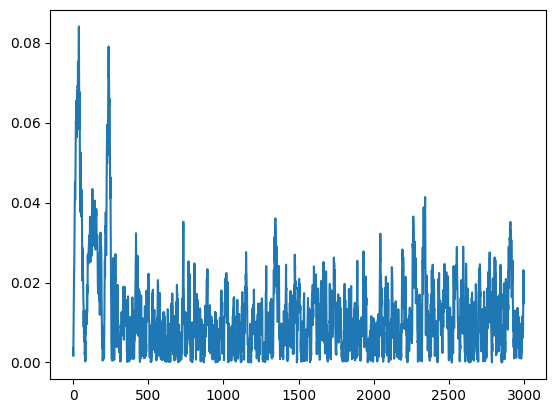

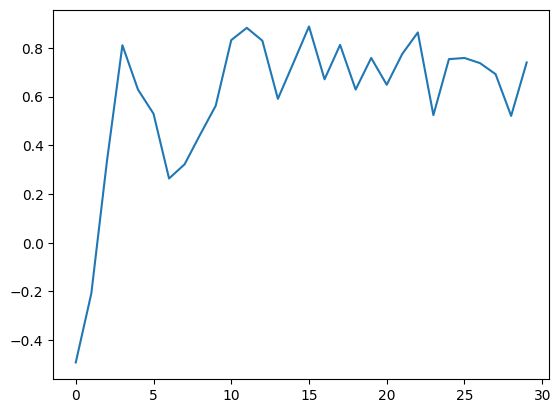

In [141]:
full_traj_np = np.array(full_traj)
plt.plot(np.abs(full_traj_np[:,3]))

plt.figure()
plt.plot(actual_rwds)

# Nominal Gains Only

In [142]:
init_state = init_state_fixed
perf_metrics_nom = np.zeros((num_trials, 3))
actual_rwds_nom = np.zeros(num_trials) 
full_traj_nom = []

for i in range(num_trials):
    best_gain_unscaled = MPCBalancerParams().get_list()
    metrics, traj = robot.evaluate_gain(best_gain_unscaled, init_state=init_state)
    for t in range(traj.shape[0]):
        full_traj_nom.append(traj[t])
    
    metrics_scaled = np.squeeze(metric_scaler.transform(np.expand_dims(metrics, 0)))
    actual_rwd = np.dot(cost_weights, metrics_scaled)
    print(f"step {i}: actual cost = {actual_rwd}")
    print(f"step {i}: metrics = {metrics}")
    print("------------------------")
    
    perf_metrics_nom[i] = metrics
    actual_rwds_nom[i] = actual_rwd

    if not np.any(traj[-1]):
        print("resetting!")
        init_state = init_state_fixed
    else:
        init_state = traj[-1]


step 0: actual cost = -0.3991221794108226
step 0: metrics = [0.01566396 0.22915928 4.75229603]
------------------------
step 1: actual cost = 0.038817967021099714
step 1: metrics = [0.01237171 0.16941931 3.7447004 ]
------------------------
step 2: actual cost = 0.5884569528444028
step 2: metrics = [0.00992996 0.04647324 3.50126507]
------------------------
step 3: actual cost = 0.6667255671398008
step 3: metrics = [0.00567099 0.02027707 3.80892602]
------------------------
step 4: actual cost = 0.4588552680254647
step 4: metrics = [2.08275131e-03 6.23244865e-02 4.16991954e+00]
------------------------
step 5: actual cost = 0.5629466097863456
step 5: metrics = [1.77097551e-03 6.84671089e-02 3.45308980e+00]
------------------------
step 6: actual cost = 0.4942774785695249
step 6: metrics = [1.54826460e-03 6.61101893e-02 3.90364783e+00]
------------------------
step 7: actual cost = 0.6294575551147576
step 7: metrics = [2.03936001e-03 4.32941996e-02 3.63529411e+00]
----------------------

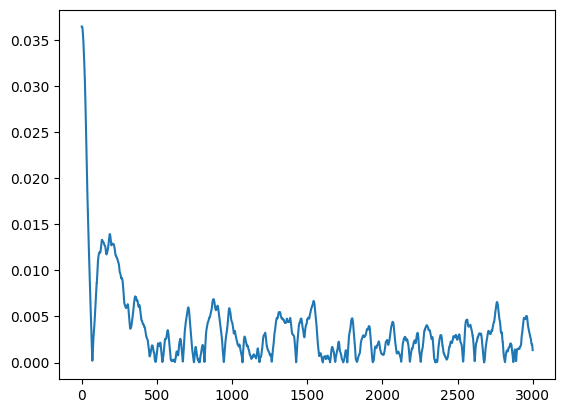

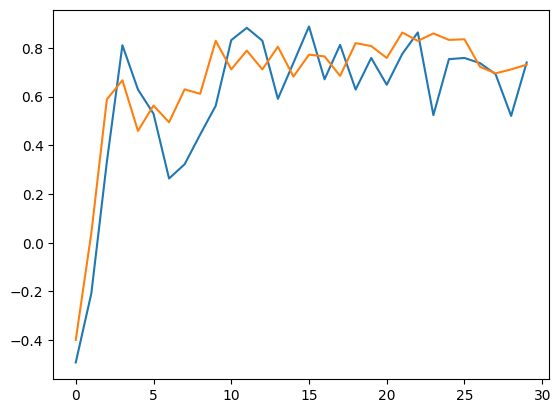

In [143]:
full_traj_nom_np = np.array(full_traj_nom)
plt.plot(np.abs(full_traj_nom_np[:,1]))

plt.figure()
plt.plot(actual_rwds)
plt.plot(actual_rwds_nom)